In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import datasets

/home/jyang4/miniconda3/envs/BE-205/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#for testing only
# words = open("names.txt").read().splitlines() # Load the words
# len(words)

18239

In [3]:
ds = datasets.load_dataset("damlab/uniprot")
words = ds["train"]["sequence"]
print(words[0])
#Subset the dataset a lot to reduce training time
words = train_test_split(words, test_size=0.99, random_state=42)[0]
len(words)

Found cached dataset parquet (/home/jyang4/.cache/huggingface/datasets/damlab___parquet/damlab--uniprot-28c00e1433a53e45/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
100%|██████████| 1/1 [00:00<00:00, 103.08it/s]


MAFSAEDVLKEYDRRRRMEALLLSLYYPNDRKLLDYKEWSPPRVQVECPKAPVEWNNPPSEKGLIVGHFSGIKYKGEKAQASEVDVNKMCCWVSKFKDAMRRYQGIQTCKIPGKVLSDLDAKIKAYNLTVEGVEGFVRYSRVTKQHVAAFLKELRHSKQYENVNLIHYILTDKRVDIQHLEKDLVKDFKALVESAHRMRQGHMINVKYILYQLLKKHGHGPDGPDILTVKTGSKGVLYDDSFRKIYTDLGWKFTPL


5669

In [4]:
chars = sorted(set("".join(words))) # Get the unique characters
char_to_id = {c: i for i, c in enumerate(chars)} # Create a mapping from characters to IDs
num_tokens = len(char_to_id)
char_to_id['.'] = num_tokens #Add stop token
id_to_char = {i: c for i, c in enumerate(chars)} # Create a mapping from IDs to characters
id_to_char[num_tokens] = '.' #Add stop token

num_tokens = len(char_to_id)

In [5]:
#tiktoken is a byte tokenization method that is more efficient
#common strings get concatenated to keep a smaller vocabulary

In [6]:
def make_dataset(words, context_length=10):
    """
    Creates encoding dataset from a list of words
    Args: List of words
    Returns: X, y
    X: Encodings of contexts
    y: Encodings of the next character
    """
    X, y = [], []
    for word in words:
        context = [0] * context_length
        for char in word + '.':
            X.append(context)
            y.append(char_to_id[char])
            context = context[1:] + [char_to_id[char]]
    X, y = torch.tensor(X), torch.tensor(y)
    return X, y

In [9]:
# embedding_dim = 16 # Embedding dimension
# C = nn.Embedding(num_tokens, embedding_dim) # Embedding layer
# C(X).shape #batch size x context length x embedding size

In [7]:
context_length = 20 # Length of the context
X_all, y_all = make_dataset(words, context_length)
data_loader = DataLoader(TensorDataset(X_all, y_all), batch_size=2048, shuffle=True)
len(X_all)

2082557

In [8]:
class ConvolutionalModel(nn.Module):
    def __init__(self, embed_dim=128, hidden_dim=64, num_tokens=num_tokens, context_length=context_length):
        """
        Convolutional architecture, lower costs than transformer and may be just as expressive.
        """
        super().__init__()
        self.inp_dim = embed_dim * context_length
        self.C = nn.Embedding(num_tokens, embed_dim)
        self.conv1 = nn.Conv1d(in_channels=context_length, out_channels=hidden_dim, kernel_size=5, padding="same")
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(in_channels=hidden_dim, out_channels=hidden_dim, kernel_size=5, padding="same")
        self.conv3 = nn.Conv1d(in_channels=hidden_dim, out_channels=hidden_dim, kernel_size=5, padding="same")
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(hidden_dim * embed_dim, num_tokens)
        
    def forward(self, x):
        x = self.C(x) #output is batch size x context length x embedding size
        h = self.conv1(x)
        h = self.relu(h)
        h = self.conv2(h)
        h = self.relu(h)
        h = self.conv3(h)
        h = self.relu(h)
        h = self.flatten(h)
        x = self.fc(h)
        return x

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model = ConvolutionalModel()
model.to(device)
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
losses = []

for epoch in range(10):
    total_loss = 0
    for step, batch in enumerate(data_loader):
        optimizer.zero_grad()
        x = batch[0].to(device)
        y = batch[1].to(device)

        y_pred = model(x)
        loss = F.cross_entropy(y_pred, y, reduction="sum")
        total_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_loss = total_loss / len(X_all)
    losses.append(avg_loss)

    if epoch % 1 == 0:
        print(f"Epoch {epoch + 1}, loss {avg_loss:.2f}")
        

cuda
Epoch 1, loss 2.88
Epoch 2, loss 2.86
Epoch 3, loss 2.85
Epoch 4, loss 2.85
Epoch 5, loss 2.84
Epoch 6, loss 2.84
Epoch 7, loss 2.83
Epoch 8, loss 2.83
Epoch 9, loss 2.82
Epoch 10, loss 2.82


In [12]:
-torch.log(torch.tensor(1/num_tokens))

tensor(3.1781)

In [13]:
for name, param in model.named_parameters():
    if name == "C.weight":
        weights = param.cpu().detach().numpy()

Text(0, 0.5, 'PC2')

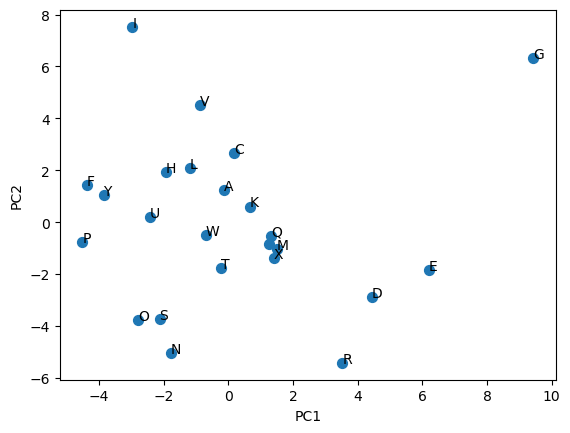

In [14]:
pca = PCA(n_components=2)
transformed = pca.fit_transform(weights)

plt.scatter(transformed[:, 0], transformed[:, 1], s=50)
for i, char in enumerate(chars):
    plt.annotate(char, xy=(transformed[i, 0], transformed[i, 1]))
plt.xlabel("PC1")
plt.ylabel("PC2")